# Node Classifier

First experiment with a `node` classifier, node classifiers run the graph convolution on the entire network and output a result for every single node in the graph per each training epoch. This is very different that a mini-batch sort of set-up, each epoch is basically one big batch.

The simplest forms of graph NN's use nodes and node properties. That is why in this first example we use a graph with 3 nodes types
- The customer node with age, gender as properties
- The merchant node with category as property
- A payment node with scaled amount as property

And 2 edge types (no edge properties for now)
- From customer to payment
- From payment to merchant

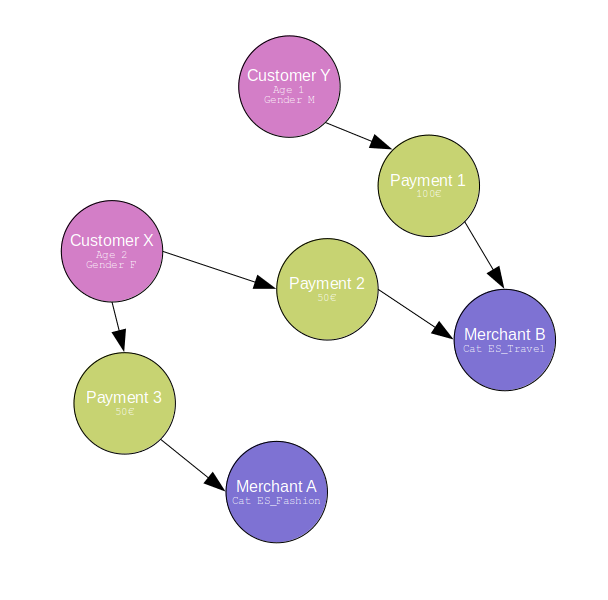

Because of the 3 node types this is a __heterogeneous__ graph, meaning the nodes have a different type. Homogeneous networks, where there is only one type of node are slightly easier to work with.

Our label (fraud vs non-fraud) is on the payment node, so the objective will be to predict **which of the payment nodes are fraud.**

### Observation about the set-up and fraud
This notebook will introduce some of the concepts. But we can not expect fantastic results. This set-up suffers from a number of problems. Mainly due to the fact that fraud data is inherently temporal. It spans a certain period of time, and it not a snapshot at a particular point in time.
- A very typical problem with graphs on temporal data is data-leakage. Data leakage can broadly be defined as 'leaking' information into the training process which will make it perform better during training than in a production environment. A typical example would be to give it information in training which in a production environment would not be available at time of inference. This network is basically one big leak, it shows contains all of the information of all payments. So it sort of give the network a view into the future.
- Equally intuition would lead us to believe that some types of fraud manifest themselves as a sequence of events over time. In these networks, the time dimesion seems to be lost and can not be used by the algorithm.

One would for sure not want to do this to classify payments in an ex-ante style. I.e. where you assess the payment or transaction as it is being processed.

---
#### Note on the data set 
The data set used here (https://www.kaggle.com/datasets/ealaxi/banksim1) is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import gc

import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl
import d373c7.network as nw
import d373c7.pytorch.graph.geometric as geo

import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, Linear, HeteroConv

from typing import Tuple

In [ ]:
pip install wheel
sudo apt-get install python3.x-dev

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

## Define some Pandas dataframes we will use as input for our network
We will create one Pandas for each node-type and one pandas for each edge-type

In [4]:
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT_32)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

payment_id = ft.FeatureSource('payment_id', ft.FEATURE_TYPE_INT_32)
customer_id = ft.FeatureSource('customer_id', ft.FEATURE_TYPE_INT_32)
merchant_id = ft.FeatureSource('merchant_id', ft.FEATURE_TYPE_INT_32)

age_oh = ft.FeatureOneHot('age_oh', ft.FEATURE_TYPE_INT_8, age)
gender_oh = ft.FeatureOneHot('gender_oh', ft.FEATURE_TYPE_INT_8, gender)
category_oh = ft.FeatureOneHot('category_oh', ft.FEATURE_TYPE_INT_8, category)

amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])


raw_td = ft.TensorDefinition(
    'raw',
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

label_td = ft.TensorDefinition(
    'labels',
    [fraud]
)

customer_node_td = ft.TensorDefinition(
    'customer_node', 
    [
        customer_id,
        age_oh,
        gender_oh
    ])

merchant_node_td = ft.TensorDefinition(
    'merchant_node', 
    [
        merchant_id,
        category_oh
    ])

payment_node_td = ft.TensorDefinition(
    'payment_node', 
    [
        payment_id,
        amount_scale
    ])

customer_to_payment_edge_td = ft.TensorDefinition(
    'customer_to_payment_edge', 
    [
        customer_id,
        payment_id,
    ])

payment_to_merchant_edge_td = ft.TensorDefinition(
    'customer_to_payment_edge', 
    [
        merchant_id,
        payment_id
    ])

with en.EnginePandasNumpy(num_threads=1) as e:
    df_raw = e.from_csv(raw_td, file, inference=False)
    
# Add unique index to the payment df.
df_raw['payment_id'] = df_raw.index

# Add a unique id per each customer and merchant
df_raw['customer_id'] = pd.factorize(df_raw['customer'])[0]
df_raw['merchant_id'] = pd.factorize(df_raw['merchant'])[0]

with en.EnginePandasNumpy(num_threads=1) as e:
    df_cn = e.from_df(customer_node_td, df_raw, raw_td, inference=False)
    df_mn = e.from_df(merchant_node_td, df_raw, raw_td, inference=False)
    df_pn = e.from_df(payment_node_td, df_raw, raw_td, inference=False)
    df_cpe = e.from_df(customer_to_payment_edge_td, df_raw, raw_td, inference=False)
    df_pme = e.from_df(payment_to_merchant_edge_td, df_raw, raw_td, inference=False)
    df_labels = e.from_df(label_td, df_raw, raw_td, inference=False)

# Make customer and merchant data unique
df_cn = df_cn.drop_duplicates(subset=['customer_id'])
df_mn = df_mn.drop_duplicates(subset=['merchant_id'])

# Labels to numpy
labels = df_labels.to_numpy()

2022-07-07 16:55:53.768 d373c7.engines.common          INFO     Start Engine...
2022-07-07 16:55:53.768 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-07-07 16:55:53.768 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-07-07 16:55:53.769 d373c7.engines.panda_numpy     INFO     Building Panda for : raw from file ../../../../data/bs140513_032310.csv
2022-07-07 16:55:54.011 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-07-07 16:55:54.012 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-07-07 16:55:54.018 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 8)
2022-07-07 16:55:54.019 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: raw
2022-07-07 16:55:54.057 d373c7.engines.common          INFO     Start Engine...
2022-07-07 16:55:54.058 d373c7.engines.panda_numpy     INFO     Pandas Version : 1

### Define a network structure

In [5]:
# Define Nodes
customer_node = nw.NetworkNodeDefinitionPandas('customer', customer_id, customer_node_td, df_cn)
merchant_node = nw.NetworkNodeDefinitionPandas('merchant', merchant_id, merchant_node_td, df_mn)
payment_node = nw.NetworkNodeDefinitionPandas('payment', payment_id, payment_node_td, df_pn)

# Define Edges
customer_to_payment_edge = nw.NetworkEdgeDefinitionPandas(
    name = 'customer_to_payment',
    id_feature = payment_id,
    from_node = customer_node,
    from_node_id = customer_id,
    to_node = payment_node,
    to_node_id = payment_id,
    td = customer_to_payment_edge_td,
    df = df_cpe
)

payment_to_merchant_edge = nw.NetworkEdgeDefinitionPandas(
    name = 'payment_to_merchant',
    id_feature = payment_id,
    from_node = payment_node,
    from_node_id = payment_id,
    to_node = merchant_node,
    to_node_id = merchant_id,
    td = payment_to_merchant_edge_td,
    df = df_pme
)

# Now define the network
network = nw.NetworkDefinitionPandas(
    'network', 
    [customer_node, merchant_node, payment_node], 
    [customer_to_payment_edge, payment_to_merchant_edge]
)

### Set-up a Geometric data set.
Geometric uses a specific input data set for heterogeneous data named 'HeteroData'. Here we create a 'HeteroData', feed it the network, the labels and the split validation vs test.

In [6]:
labels = torch.as_tensor(labels, dtype=torch.float32)
g = geo.GeometricHeteroData(network, [labels], 30000, 100000)

Note how the dataset we will used has been turned into an undirected graph. The 'rev\_\*' edges have been added. They are needed so 'messages' can flow both ways over the edges.

In [7]:
print(g.hetero_undirected)

HeteroData(
  customer={ x=[4112, 12] },
  merchant={ x=[50, 15] },
  payment={ x=[594643, 1] },
  (customer, customer_to_payment, payment)={ edge_index=[2, 594643] },
  (payment, payment_to_merchant, merchant)={ edge_index=[2, 594643] },
  (payment, rev_customer_to_payment, customer)={ edge_index=[2, 594643] },
  (merchant, rev_payment_to_merchant, payment)={ edge_index=[2, 594643] }
)


### The Challenge
One of the typical challenges with fraud data is the massive class imbalance, we tend to have way more non-fraud records than fraud records. In this data about 1.2% of records are marked as Fraud.

In the previous examples we plain oversampled, so did not look into this imbalance too much, but in a node classification set-up, we will need another strategy. If we were to oversample we would break the original graph structure, we can not just add nodes

In [8]:
print(f'Number of labels           : {labels.shape[0]}')
print(f'Number of Fraud labels     : {np.count_nonzero(labels)}')
print(f'Number of Non-Fraud labels : {labels.shape[0] - np.count_nonzero(labels)}')
print(f'Fraud Ratio                : {np.count_nonzero(labels)/labels.shape[0]:.3f}')

Number of labels           : 594643
Number of Fraud labels     : 7200
Number of Non-Fraud labels : 587443
Fraud Ratio                : 0.012


### Define a model
This model has 2 SAGE style graph convolutional layers followed by a linear and sigmoid. The output is a score between 0 and 1 and evaluated using binary cross entropy loss.

The set-up is a bit specific, geometric has a wrapper class named HeteroConv which we can use to set-up a convolution per each edge type. In the forward that will give us a dictionary with an entry per node-type. The values of the dictionary are a tensor with the node embeddings.

We also set-up a specific `WeightedBCELoss` function. This is one of the ways we hope to cater for the class imbalance by doing class weighting. I.e. give the loss of the Fraud class a higher weight.

In [9]:
class HeteroGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = HeteroConv({
            ('customer', 'customer_to_payment', 'payment'): SAGEConv((-1, -1), 16),
            ('payment', 'payment_to_merchant', 'merchant'): SAGEConv((-1, -1), 16),
            ('payment', 'rev_customer_to_payment', 'customer'): SAGEConv((-1, -1), 16),
            ('merchant', 'rev_payment_to_merchant', 'payment'): SAGEConv((-1, -1), 16),
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('customer', 'customer_to_payment', 'payment'): SAGEConv((-1, -1), 8),
            ('payment', 'payment_to_merchant', 'merchant'): SAGEConv((-1, -1), 8),
            ('payment', 'rev_customer_to_payment', 'customer'): SAGEConv((-1, -1), 8),
            ('merchant', 'rev_payment_to_merchant', 'payment'): SAGEConv((-1, -1), 8),
        }, aggr='sum')
        self.lin = Linear(8, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        x = x_dict
        x = self.conv1(x, edge_index_dict)
        x = {key: x.relu() for key, x in x.items()}
        x = self.conv2(x, edge_index_dict)
        x = {key: x.relu() for key, x in x.items()}
        # Only select the payment embedding, we're not using the customer and merchant embeddings going further.
        x = self.lin(x['payment'])
        x = self.sig(x)
        return x
        
model = HeteroGNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

class WeightedBCELoss:
    def __init__(self, weights: Tuple[float, float]):
        self._weights = torch.as_tensor(weights)
        self._loss = nn.BCELoss(reduction='none')

    def __call__(self, *args, **kwargs):
        x = args[0]
        y = args[1]
        w = self._weights[y.long()]
        il = self._loss(x, y)
        return torch.mean(il * w)

loss_fn = WeightedBCELoss((1.0,2.5))

In [10]:
model

HeteroGNN(
  (conv1): HeteroConv(num_relations=4)
  (conv2): HeteroConv(num_relations=4)
  (lin): Linear(8, 1, bias=True)
  (sig): Sigmoid()
)

### Run 50 epochs
The sampling is specific to network data and to node classification. We would want a train, validation and test set, but in a node classification set-up each time we are running the entire graph through the model. And that is what we want, if we would split up the graph into smaller pieces, the model would loose sight of the overall structure. 

A way around that is to use the entire graph, but only calculate the loss on a portion of the graph. So we mark some nodes as training, some as validation and some as test. That is done via a 'mask'. Masks are boolean tensor, containing True or False for each entry of the input. 

Note that here we also use the mask for sampling purposes. The 'random_sampled_train_mask' will take all the fraud in the data set, and add a factor of the fraud count, randomly sampled non-fraud record. 

If the factor is 3 then each training mask will have 3 times the number of fraud records as non-fraud records. This was done so as to speed the training up. Otherwise we would only be evaluating `2 * #fraud_records_in_training`.

Because this model sees far from all the non-fraud each epoch, we run a bit more epochs than the previous examples.

In [11]:
print(f'Number training nodes       : {torch.count_nonzero(g.train_mask)}')
print(f'Number validation nodes     : {torch.count_nonzero(g.validation_mask)}')
print(f'Number test nodes           : {torch.count_nonzero(g.test_mask)}')
print(f'Training Fraud records      : {torch.count_nonzero(labels[g.train_mask])}')
print(f'Random training sample@1.0  : {torch.count_nonzero(g.random_under_sampled_train_mask(1.0))}')
print(f'Random training sample@3.0  : {torch.count_nonzero(g.random_under_sampled_train_mask(3.0))}')

Number training nodes       : 464643
Number validation nodes     : 30000
Number test nodes           : 100000
Training Fraud records      : 5796
Random training sample@1.0  : 11592
Random training sample@3.0  : 23182


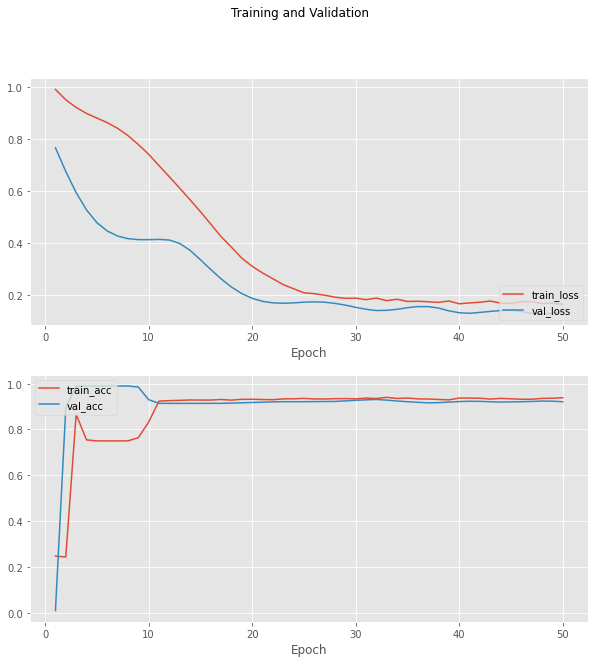

In [12]:
NUM_EPOCH = 50

def train(gmd: geo.GeometricHeteroData, model: torch.nn.Module, history: geo.GraphBinaryClassifierHistory):
    model.train()
    optimizer.zero_grad()
    mask = gmd.random_under_sampled_train_mask(3.0)
    out = model(gmd.hetero_undirected.x_dict, gmd.hetero_undirected.edge_index_dict, gmd.hetero_undirected.edge_attr_dict)
    loss_p = loss_fn(out[mask], gmd.labels[0][mask])
    loss = loss_p
    # loss = loss_fn(out['payment'][mask], gmd.labels[0][mask])
    history.end_step(out, gmd.labels, loss, mask)
    history.end_epoch()
    loss.backward()
    optimizer.step()
    
def validate(gmd: geo.GeometricHeteroData, model: torch.nn.Module, history: geo.GraphBinaryClassifierHistory):
    with torch.no_grad():
        model.eval()
        mask = gmd.validation_mask
        out = model(gmd.hetero_undirected.x_dict, gmd.hetero_undirected.edge_index_dict, gmd.hetero_undirected.edge_attr_dict)
        loss = loss_fn(out[mask], gmd.labels[0][mask])
        history.end_step(out, gmd.labels, loss, mask)
        history.end_epoch()

th = geo.GraphBinaryClassifierHistory()
vh = geo.GraphBinaryClassifierHistory()

for e in range(NUM_EPOCH):
    train(g, model, th)
    validate(g, model, vh)

pl.TrainPlot().plot_history((th, vh), fig_size=(10,10))

### Test

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     98926
         1.0       0.13      0.99      0.22      1074

    accuracy                           0.93    100000
   macro avg       0.56      0.96      0.59    100000
weighted avg       0.99      0.93      0.95    100000


auc score : 0.9887
ap score  : 0.6476
-----------------------------------------------------


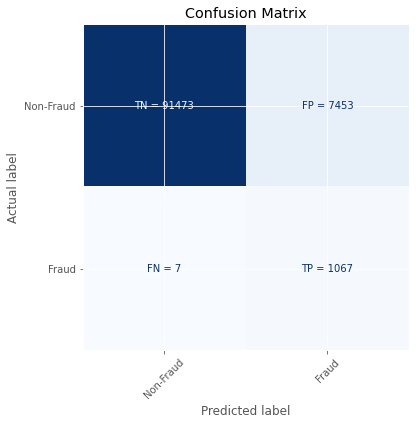

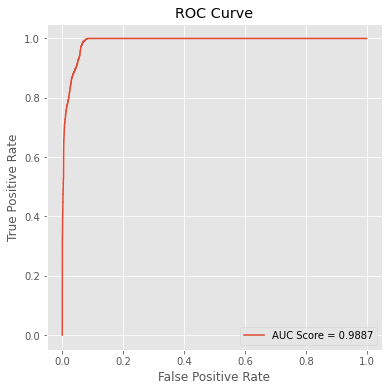

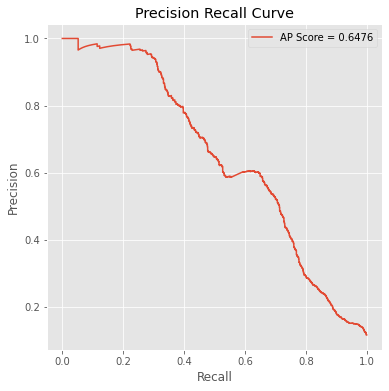

In [13]:
def test(gmd: geo.GeometricHeteroData, model: torch.nn.Module):
    with torch.no_grad():
        model.eval()
        mask = gmd.test_mask
        pr = model(gmd.hetero_undirected.x_dict, gmd.hetero_undirected.edge_index_dict, gmd.hetero_undirected.edge_attr_dict)
        lb = torch.squeeze(gmd.labels[0][mask]).cpu().numpy()
        pr = pr[mask].cpu().numpy()
    return pr, lb

pr = test(g, model)

tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

# Conclusion
This first example is probably not something one would do in real life, but it managed to introduce some of the concepts. It should hopefully have make clear why this is not such a good idea. Mainly because of the leakage problem, equally the sampling was a bit of a pain.